In [ ]:
from google.colab import files
uploaded = files.upload()
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


Saving mobilenetv2_ecg_model.h5 to mobilenetv2_ecg_model.h5
Saving resnet50_ecg_model.h5 to resnet50_ecg_model.h5
Saving optimized_custom_ecg_model.h5 to optimized_custom_ecg_model.h5
Saving cusom_ecg_model.h5 to cusom_ecg_model.h5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
zip_path = '/content/drive/MyDrive/ECG_Project/augmented_ecg_images_balanced.zip'
extract_to = '/content/ecg_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (384, 384)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = datagen.flow_from_directory(
    '/content/ecg_dataset/augmented_ecg_images_balanced',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 1640 images belonging to 4 classes.


In [ ]:
model_custom = tf.keras.models.load_model('cusom_ecg_model.h5')
model_mobilenet = tf.keras.models.load_model('mobilenetv2_ecg_model.h5')
model_optimized = tf.keras.models.load_model('optimized_custom_ecg_model.h5')
model_resnet = tf.keras.models.load_model('resnet50_ecg_model.h5')


In [ ]:
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    return y_true, predictions


In [ ]:
y_true, pred_custom = evaluate_model(model_custom, val_generator)
_, pred_mobilenet = evaluate_model(model_mobilenet, val_generator)
_, pred_optimized = evaluate_model(model_optimized, val_generator)
_, pred_resnet = evaluate_model(model_resnet, val_generator)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step
Classification Report:
                       precision    recall  f1-score   support

   Abnormal_Heartbeat       0.92      0.98      0.95       466
        History_of_MI       0.99      0.90      0.94       412
Myocardial_Infarction       0.98      0.99      0.99       478
               Normal       0.96      0.98      0.97       284

             accuracy                           0.96      1640
            macro avg       0.96      0.96      0.96      1640
         weighted avg       0.96      0.96      0.96      1640

Confusion Matrix:
[[455   5   6   0]
 [ 31 369   2  10]
 [  2   0 475   1]
 [  6   0   0 278]]
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 294ms/step
Classification Report:
                       precision    recall  f1-score   support

   Abnormal_Heartbeat       0.96      0.88      0.92       466
        History_of_MI       0.87      0.90      0.88       412
Myocardial_Infarction       0.94      0.95      0.94       478
               

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def get_metrics(model, val_generator, name):
    preds = model.predict(val_generator)
    y_pred = np.argmax(preds, axis=1)
    y_true = val_generator.classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {
        "name": name,
        "accuracy": report["accuracy"],
        "precision": np.mean([report[label]["precision"] for label in report if label.isdigit()]),
        "recall": np.mean([report[label]["recall"] for label in report if label.isdigit()]),
        "f1": np.mean([report[label]["f1-score"] for label in report if label.isdigit()]),
        "confusion_matrix": cm,
        "labels": list(val_generator.class_indices.keys())
    }


In [ ]:
def plot_bar_chart(metrics_list):
    names = [m["name"] for m in metrics_list]
    accuracies = [m["accuracy"] for m in metrics_list]
    precisions = [m["precision"] for m in metrics_list]
    recalls = [m["recall"] for m in metrics_list]
    f1s = [m["f1"] for m in metrics_list]

    x = np.arange(len(names))
    width = 0.2

    plt.figure(figsize=(10,6))
    plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
    plt.bar(x - 0.5*width, precisions, width, label='Precision')
    plt.bar(x + 0.5*width, recalls, width, label='Recall')
    plt.bar(x + 1.5*width, f1s, width, label='F1 Score')

    plt.xticks(x, names)
    plt.ylim(0, 1.05)
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=0.5, linecolor='white')
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step


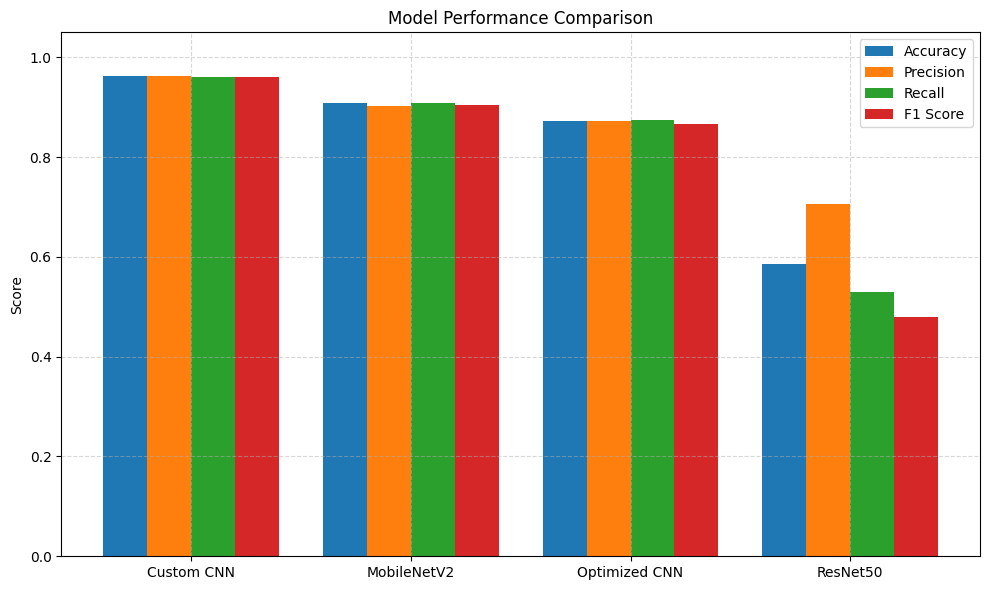

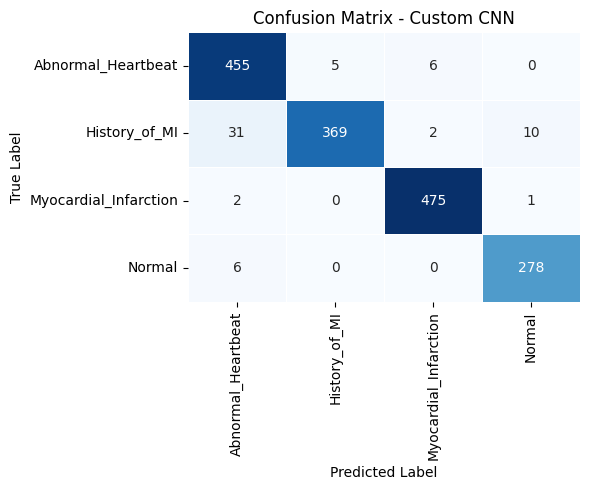

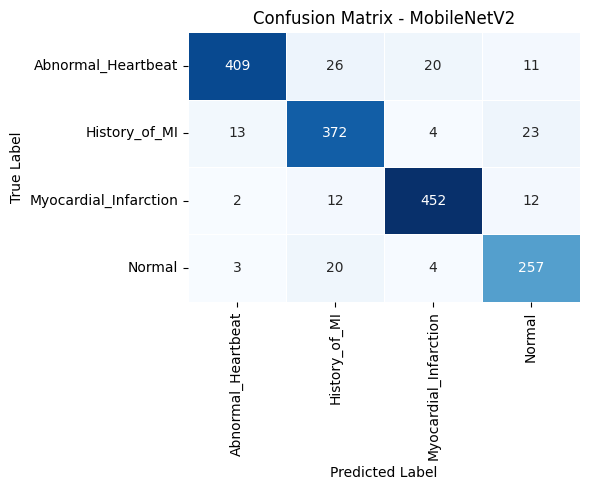

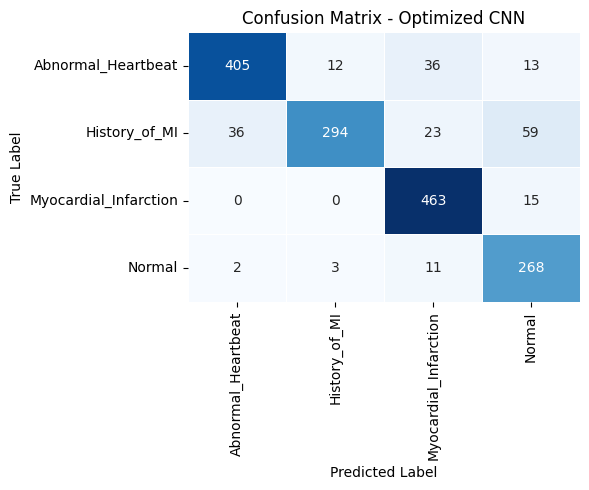

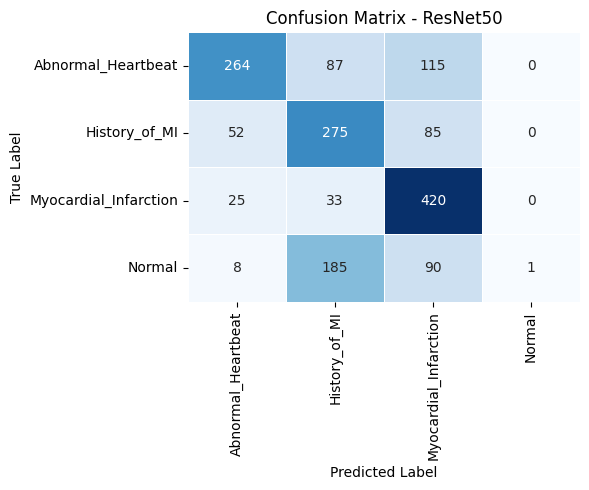

In [ ]:
metrics_custom = get_metrics(model_custom, val_generator, "Custom CNN")
metrics_mobile = get_metrics(model_mobilenet, val_generator, "MobileNetV2")
metrics_opt = get_metrics(model_optimized, val_generator, "Optimized CNN")
metrics_resnet = get_metrics(model_resnet, val_generator, "ResNet50")

all_metrics = [metrics_custom, metrics_mobile, metrics_opt, metrics_resnet]

# Plot bar chart
plot_bar_chart(all_metrics)

# Plot confusion matrices
for m in all_metrics:
    plot_confusion_matrix(m["confusion_matrix"], m["labels"], f"Confusion Matrix - {m['name']}")


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(y_true, y_score, labels, model_name):
    y_true_bin = label_binarize(y_true, classes=list(range(len(labels))))
    plt.figure(figsize=(8, 6))

    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(y_true, y_score, labels, model_name):
    y_true_bin = label_binarize(y_true, classes=list(range(len(labels))))
    plt.figure(figsize=(8, 6))

    for i in range(len(labels)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'{labels[i]} (AP = {ap:.2f})')

    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# ---------- Step 1: Evaluation + Metric Extraction ----------
def get_metrics(model, val_gen, name):
    y_score = model.predict(val_gen)
    y_pred = np.argmax(y_score, axis=1)
    y_true = val_gen.classes
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    labels = list(val_gen.class_indices.keys())
    return {
        "name": name,
        "accuracy": report["accuracy"],
        "precision": np.mean([report[k]["precision"] for k in report if k.isdigit()]),
        "recall": np.mean([report[k]["recall"] for k in report if k.isdigit()]),
        "f1": np.mean([report[k]["f1-score"] for k in report if k.isdigit()]),
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_score": y_score,
        "labels": labels
    }

# ---------- Step 2: Bar Chart ----------
def plot_bar_chart(metrics_list):
    names = [m["name"] for m in metrics_list]
    accuracies = [m["accuracy"] for m in metrics_list]
    precisions = [m["precision"] for m in metrics_list]
    recalls = [m["recall"] for m in metrics_list]
    f1s = [m["f1"] for m in metrics_list]

    x = np.arange(len(names))
    width = 0.2

    plt.figure(figsize=(10,6))
    plt.bar(x - 1.5*width, accuracies, width, label='Accuracy')
    plt.bar(x - 0.5*width, precisions, width, label='Precision')
    plt.bar(x + 0.5*width, recalls, width, label='Recall')
    plt.bar(x + 1.5*width, f1s, width, label='F1 Score')

    plt.xticks(x, names)
    plt.ylim(0, 1.05)
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ---------- Step 3: Confusion Matrix (Blue Heatmap) ----------
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar=False, linewidths=0.5, linecolor='white')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# ---------- Step 4: ROC Curve ----------
def plot_multiclass_roc(y_true, y_score, labels, model_name):
    y_true_bin = label_binarize(y_true, classes=list(range(len(labels))))
    plt.figure(figsize=(8, 6))
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# ---------- Step 5: Precision-Recall Curve ----------
def plot_pr_curve(y_true, y_score, labels, model_name):
    y_true_bin = label_binarize(y_true, classes=list(range(len(labels))))
    plt.figure(figsize=(8, 6))
    for i in range(len(labels)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, label=f'{labels[i]} (AP = {ap:.2f})')
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 256ms/step


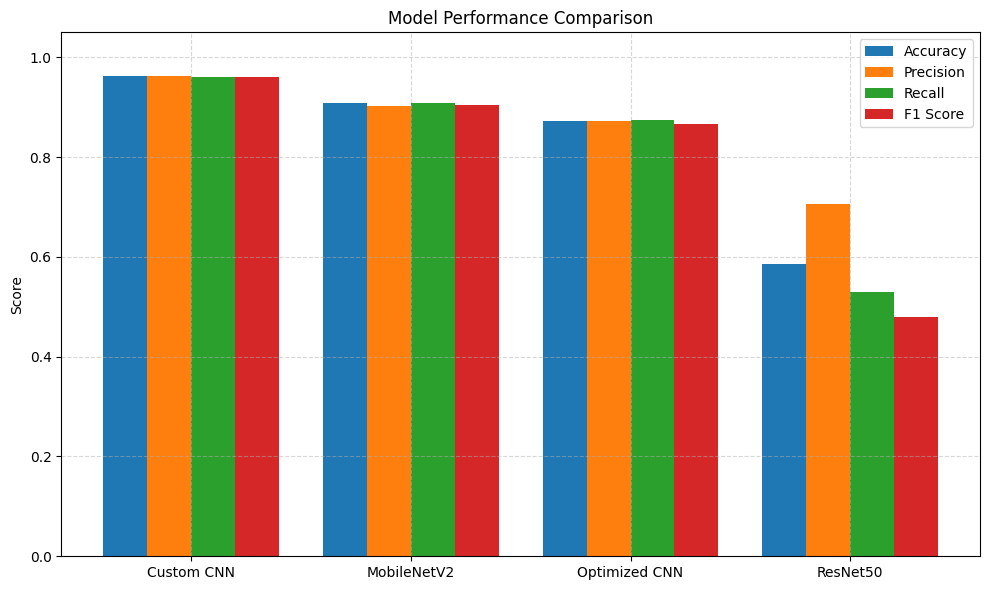

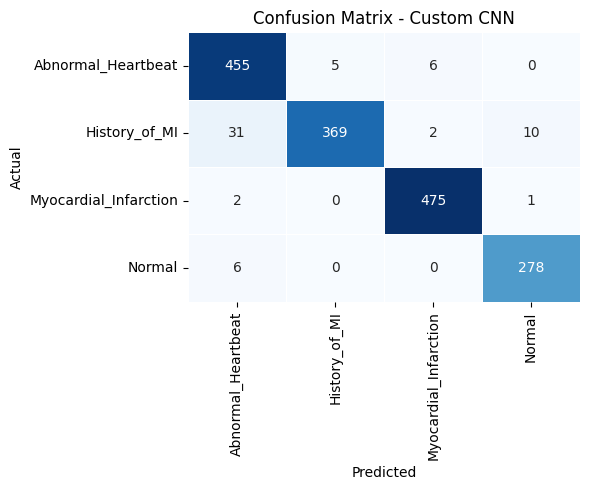

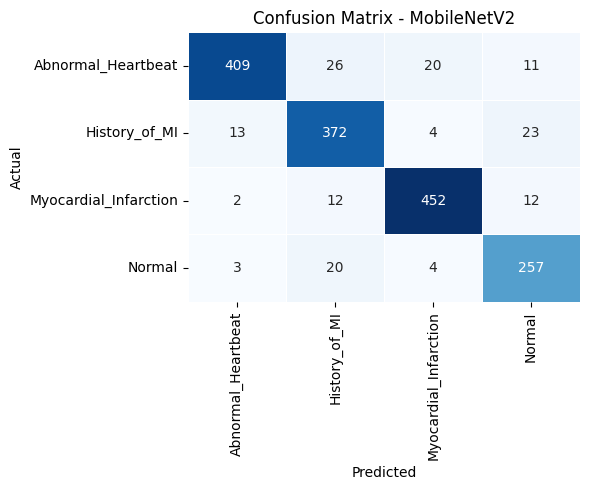

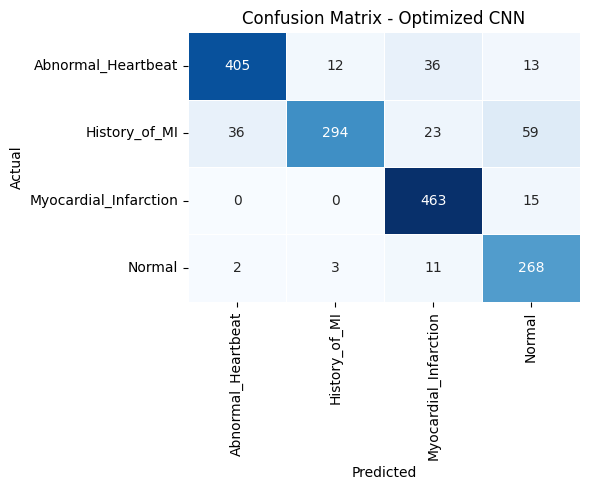

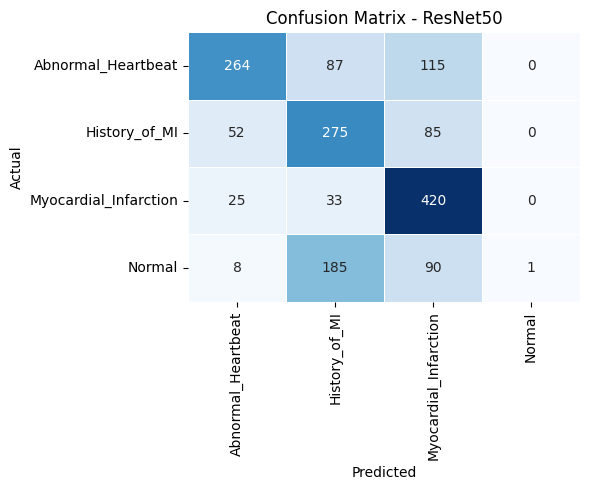

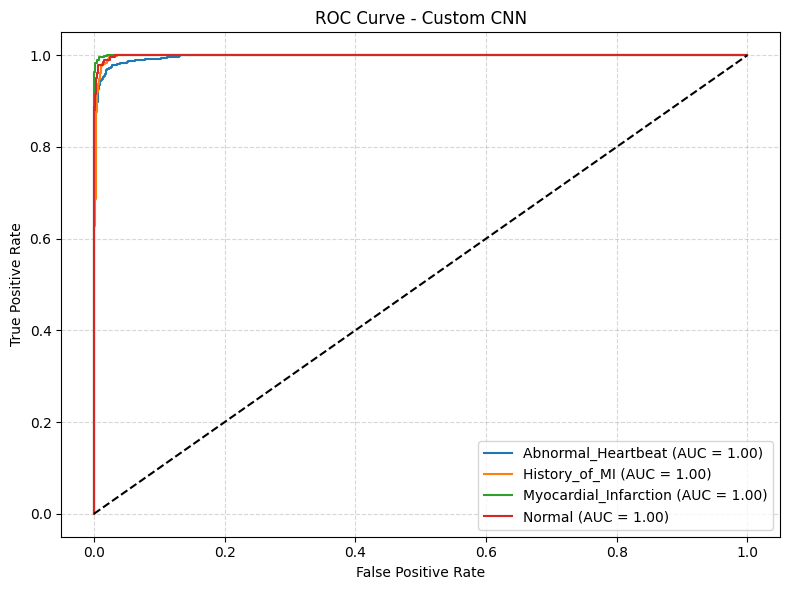

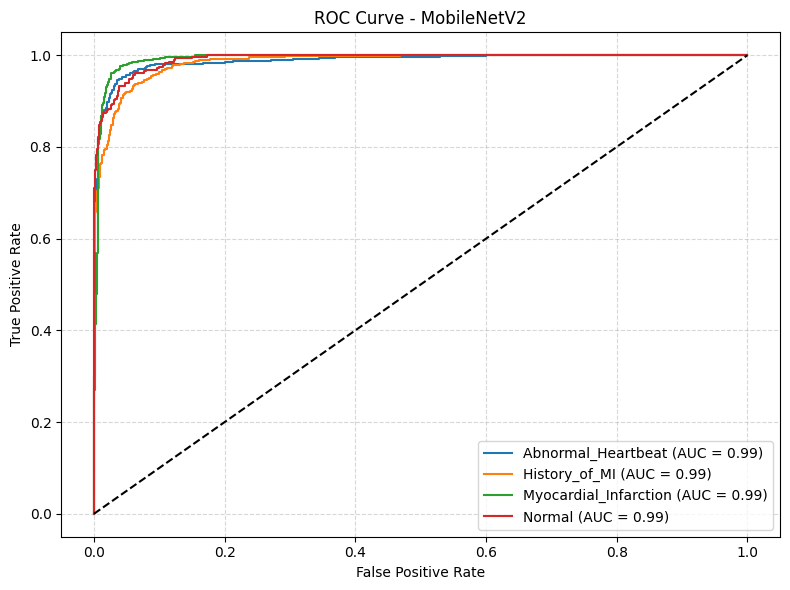

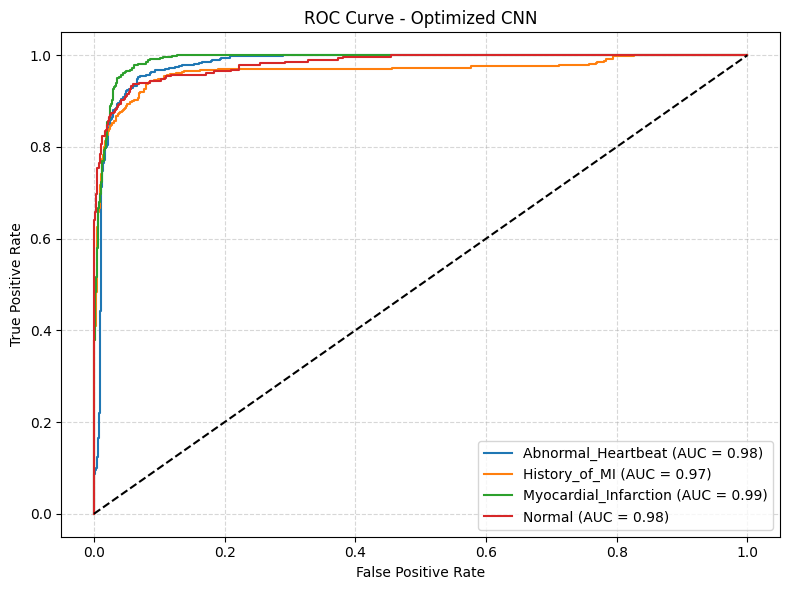

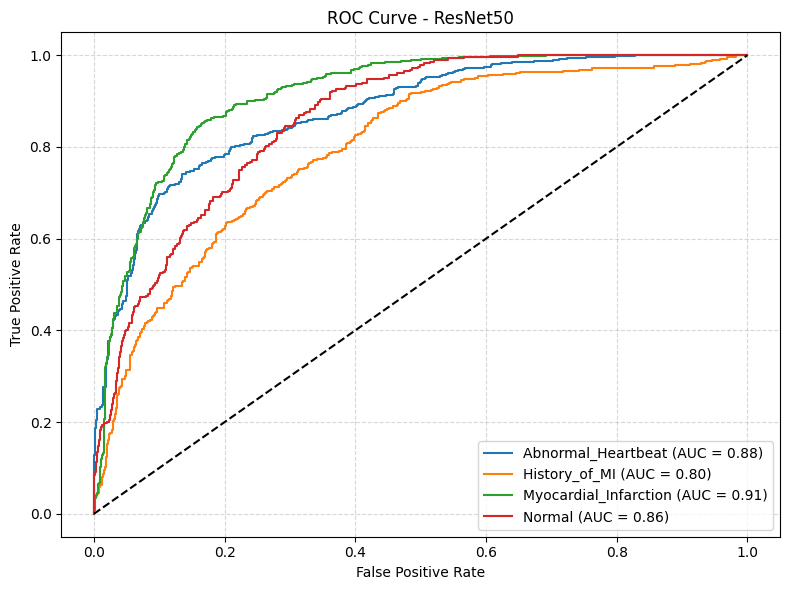

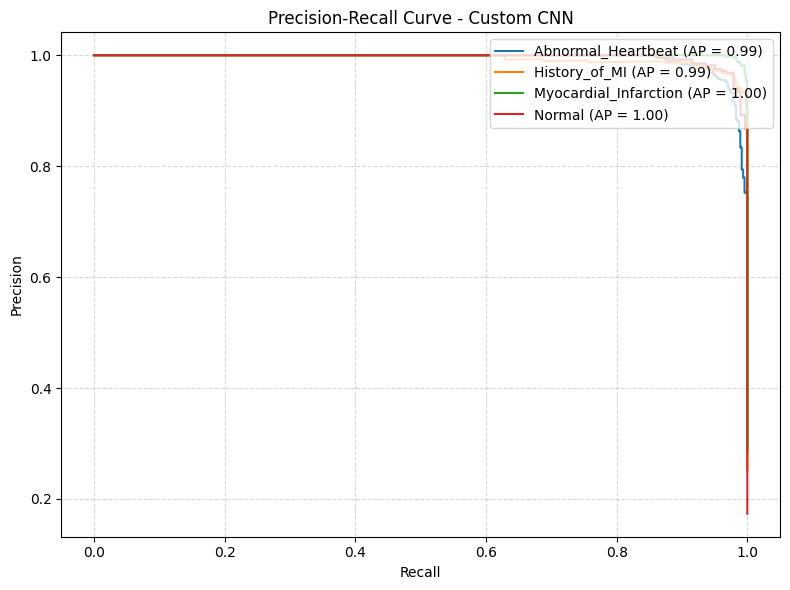

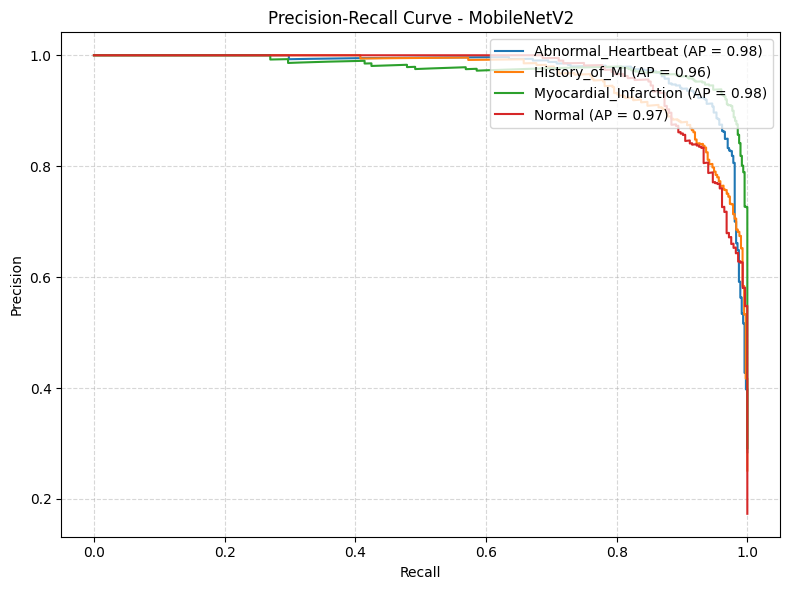

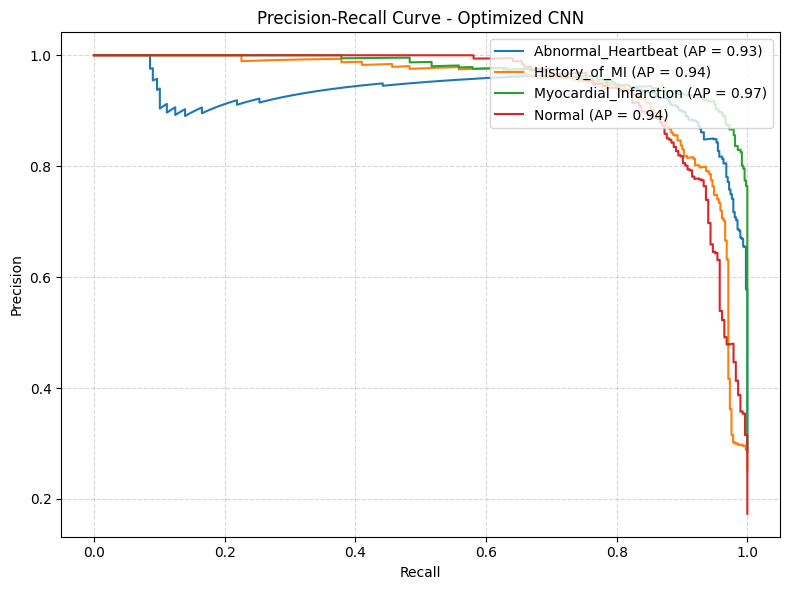

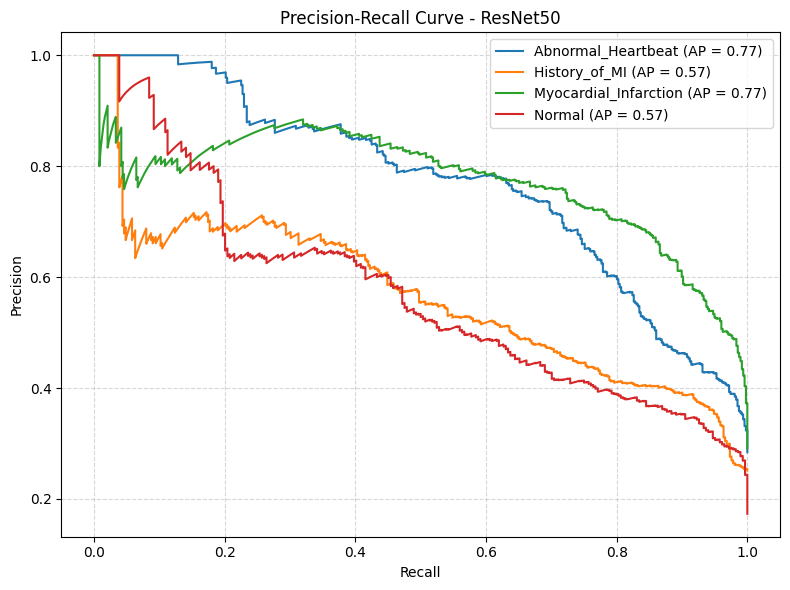

In [ ]:
metrics_custom = get_metrics(model_custom, val_generator, "Custom CNN")
metrics_mobile = get_metrics(model_mobilenet, val_generator, "MobileNetV2")
metrics_opt = get_metrics(model_optimized, val_generator, "Optimized CNN")
metrics_resnet = get_metrics(model_resnet, val_generator, "ResNet50")

all_metrics = [metrics_custom, metrics_mobile, metrics_opt, metrics_resnet]

# Bar Chart
plot_bar_chart(all_metrics)

# Confusion Matrices
for m in all_metrics:
    plot_confusion_matrix(m["confusion_matrix"], m["labels"], f"Confusion Matrix - {m['name']}")

# ROC Curves
for m in all_metrics:
    plot_multiclass_roc(m["y_true"], m["y_score"], m["labels"], m["name"])

# PR Curves
for m in all_metrics:
    plot_pr_curve(m["y_true"], m["y_score"], m["labels"], m["name"])


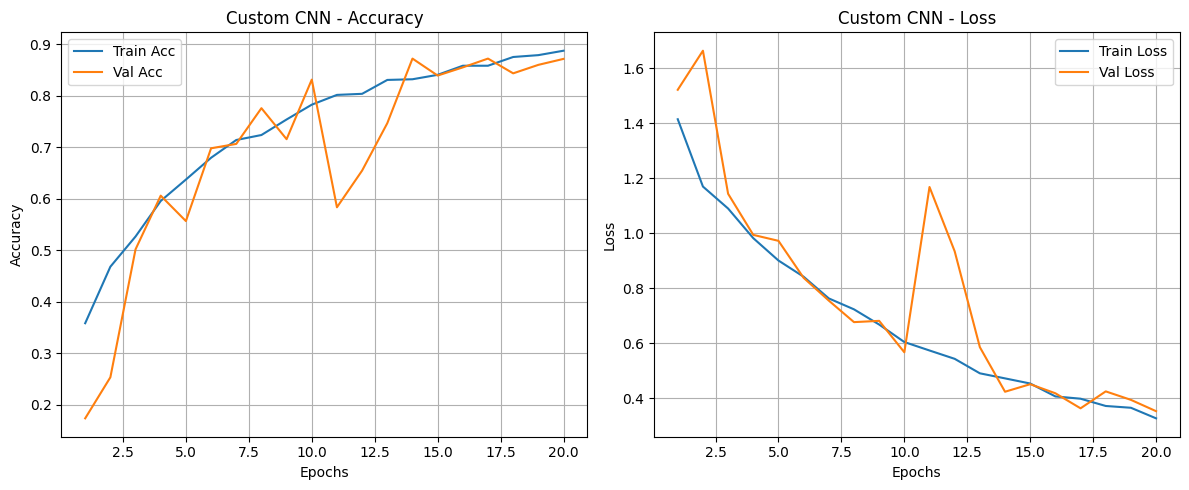

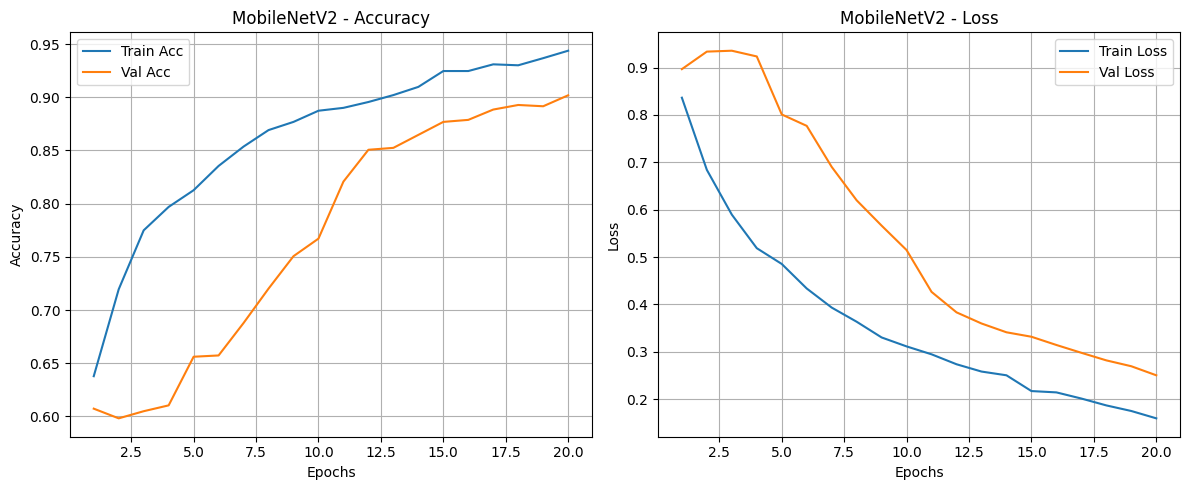

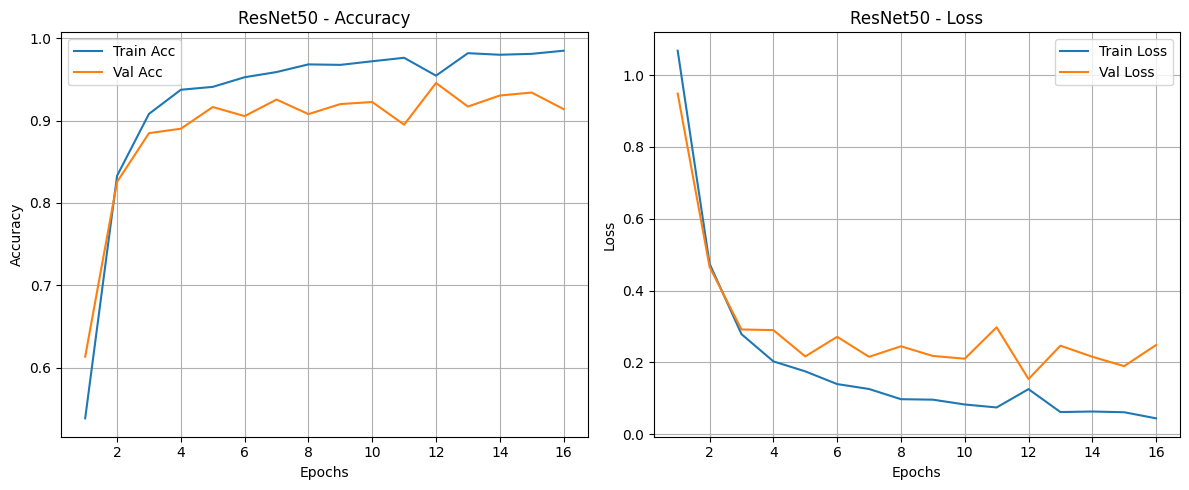

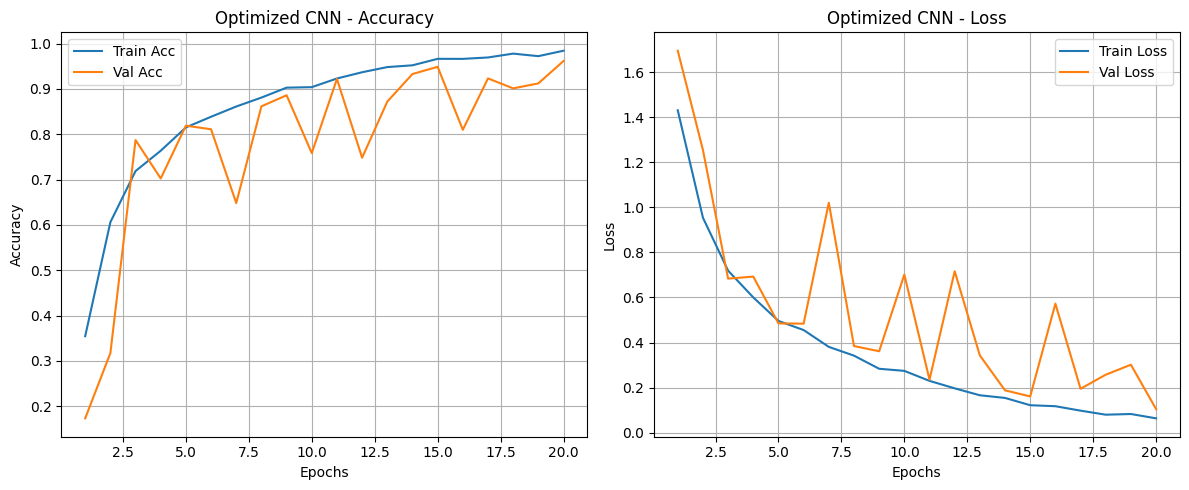

In [ ]:
import matplotlib.pyplot as plt

# Store training histories
history_custom = {
    'accuracy': [0.3581, 0.4680, 0.5267, 0.5958, 0.6374, 0.6798, 0.7143, 0.7240, 0.7542, 0.7830,
                 0.8020, 0.8041, 0.8311, 0.8324, 0.8410, 0.8587, 0.8587, 0.8757, 0.8793, 0.8879],
    'val_accuracy': [0.1732, 0.2530, 0.5018, 0.6061, 0.5567, 0.6982, 0.7067, 0.7762, 0.7159, 0.8317,
                     0.5835, 0.6549, 0.7470, 0.8726, 0.8396, 0.8555, 0.8726, 0.8439, 0.8604, 0.8720],
    'loss': [1.4141, 1.1696, 1.0898, 0.9822, 0.9010, 0.8421, 0.7634, 0.7237, 0.6685, 0.6050,
             0.5743, 0.5440, 0.4914, 0.4730, 0.4544, 0.4075, 0.3992, 0.3728, 0.3663, 0.3279],
    'val_loss': [1.5210, 1.6629, 1.1434, 0.9941, 0.9725, 0.8381, 0.7554, 0.6773, 0.6819, 0.5677,
                 1.1680, 0.9344, 0.5864, 0.4245, 0.4519, 0.4189, 0.3643, 0.4258, 0.3950, 0.3539]
}

history_mobile = {
    'accuracy': [0.6378, 0.7195, 0.7749, 0.7969, 0.8126, 0.8354, 0.8536, 0.8691, 0.8768, 0.8873,
                 0.8900, 0.8955, 0.9020, 0.9097, 0.9246, 0.9246, 0.9309, 0.9300, 0.9367, 0.9437],
    'val_accuracy': [0.6073, 0.5982, 0.6049, 0.6104, 0.6561, 0.6573, 0.6878, 0.7201, 0.7506, 0.7671,
                     0.8207, 0.8506, 0.8524, 0.8646, 0.8768, 0.8787, 0.8884, 0.8927, 0.8915, 0.9018],
    'loss': [0.8365, 0.6841, 0.5896, 0.5187, 0.4854, 0.4336, 0.3933, 0.3634, 0.3302, 0.3113,
             0.2946, 0.2736, 0.2582, 0.2503, 0.2170, 0.2142, 0.2012, 0.1867, 0.1749, 0.1594],
    'val_loss': [0.8968, 0.9338, 0.9357, 0.9236, 0.8011, 0.7770, 0.6904, 0.6198, 0.5663, 0.5147,
                 0.4264, 0.3832, 0.3597, 0.3411, 0.3317, 0.3143, 0.2978, 0.2818, 0.2694, 0.2503]
}

history_resnet = {
    'accuracy': [0.5385, 0.8331, 0.9082, 0.9375, 0.9410, 0.9527, 0.9590, 0.9683, 0.9677, 0.9721,
                 0.9763, 0.9546, 0.9819, 0.9800, 0.9811, 0.9849],
    'val_accuracy': [0.6134, 0.8256, 0.8848, 0.8902, 0.9165, 0.9055, 0.9256, 0.9079, 0.9201, 0.9226,
                     0.8951, 0.9457, 0.9171, 0.9305, 0.9341, 0.9140],
    'loss': [1.0677, 0.4745, 0.2786, 0.2028, 0.1750, 0.1396, 0.1259, 0.0975, 0.0962, 0.0828,
             0.0745, 0.1255, 0.0617, 0.0632, 0.0612, 0.0442],
    'val_loss': [0.9483, 0.4658, 0.2916, 0.2898, 0.2166, 0.2712, 0.2155, 0.2448, 0.2179, 0.2102,
                 0.2977, 0.1536, 0.2465, 0.2156, 0.1896, 0.2483]
}

history_optimized = {
    'accuracy': [0.3545, 0.6059, 0.7188, 0.7636, 0.8151, 0.8386, 0.8612, 0.8809, 0.9028, 0.9039,
                 0.9230, 0.9368, 0.9482, 0.9521, 0.9664, 0.9663, 0.9694, 0.9779, 0.9723, 0.9843],
    'val_accuracy': [0.1732, 0.3171, 0.7872, 0.7024, 0.8189, 0.8110, 0.6482, 0.8616, 0.8860, 0.7585,
                     0.9220, 0.7482, 0.8720, 0.9329, 0.9488, 0.8098, 0.9232, 0.9012, 0.9122, 0.9616],
    'loss': [1.4304, 0.9539, 0.7189, 0.6003, 0.4959, 0.4555, 0.3808, 0.3420, 0.2837, 0.2744,
             0.2300, 0.1969, 0.1661, 0.1544, 0.1220, 0.1176, 0.0979, 0.0800, 0.0830, 0.0638],
    'val_loss': [1.6947, 1.2543, 0.6836, 0.6926, 0.4850, 0.4839, 1.0202, 0.3845, 0.3614, 0.7015,
                 0.2353, 0.7162, 0.3428, 0.1880, 0.1610, 0.5725, 0.1950, 0.2573, 0.3017, 0.1049]
}

# Plotting function
def plot_training_history(history_dict, label):
    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['accuracy'], label='Train Acc')
    plt.plot(epochs, history_dict['val_accuracy'], label='Val Acc')
    plt.title(f'{label} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['loss'], label='Train Loss')
    plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
    plt.title(f'{label} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run for all models
plot_training_history(history_custom, 'Custom CNN')
plot_training_history(history_mobile, 'MobileNetV2')
plot_training_history(history_resnet, 'ResNet50')
plot_training_history(history_optimized, 'Optimized CNN')


In [ ]:
def plot_per_class_accuracy(model, generator, model_name):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    labels = list(generator.class_indices.keys())

    class_correct = [0] * len(labels)
    class_total = [0] * len(labels)

    for i in range(len(y_true)):
        class_total[y_true[i]] += 1
        if y_pred_classes[i] == y_true[i]:
            class_correct[y_true[i]] += 1

    acc = [c / t if t != 0 else 0 for c, t in zip(class_correct, class_total)]

    print(f"Class-wise Accuracies for {model_name}:")
    for lbl, a in zip(labels, acc):
        print(f"{lbl}: {a:.2f}")

    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    plt.bar(labels, acc)
    plt.ylim(0,1)
    plt.title(f'Per-Class Accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 261ms/step
Class-wise Accuracies for Custom CNN:
Abnormal_Heartbeat: 0.98
History_of_MI: 0.90
Myocardial_Infarction: 0.99
Normal: 0.98


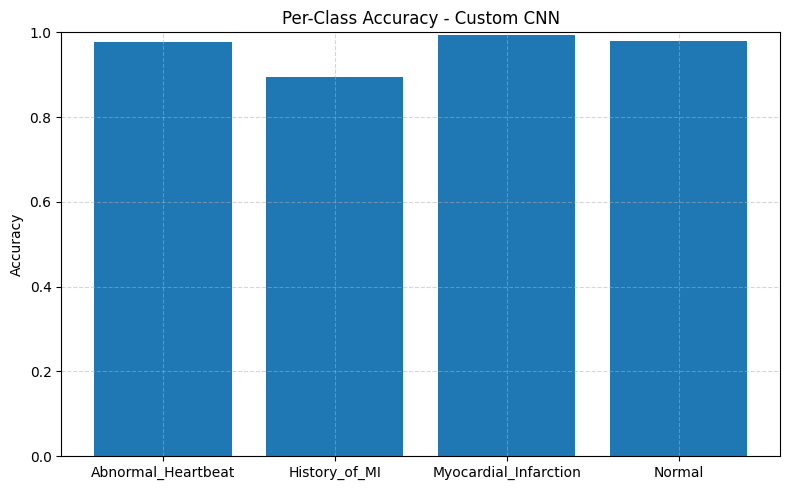

52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step
Class-wise Accuracies for MobileNetV2:
Abnormal_Heartbeat: 0.88
History_of_MI: 0.90
Myocardial_Infarction: 0.95
Normal: 0.90


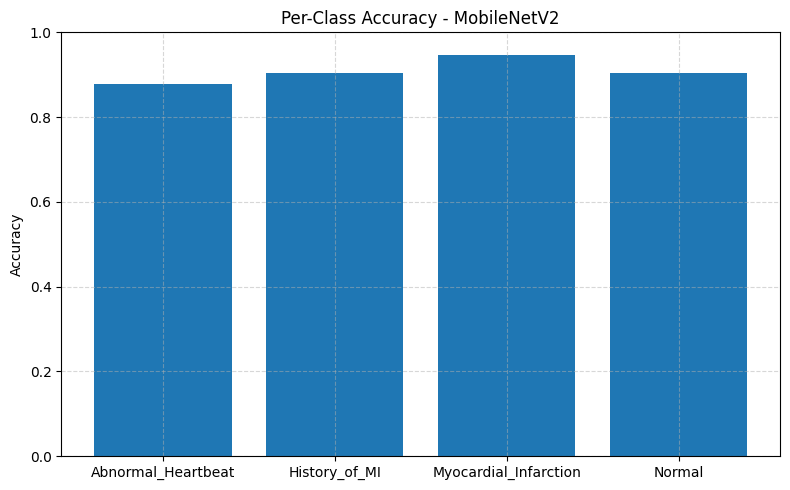

52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step
Class-wise Accuracies for Optimized CNN:
Abnormal_Heartbeat: 0.87
History_of_MI: 0.71
Myocardial_Infarction: 0.97
Normal: 0.94


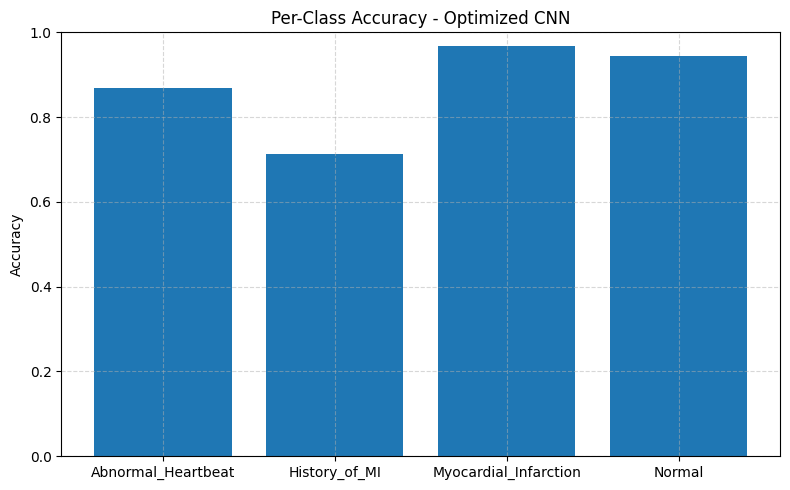

52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step
Class-wise Accuracies for ResNet50:
Abnormal_Heartbeat: 0.57
History_of_MI: 0.67
Myocardial_Infarction: 0.88
Normal: 0.00


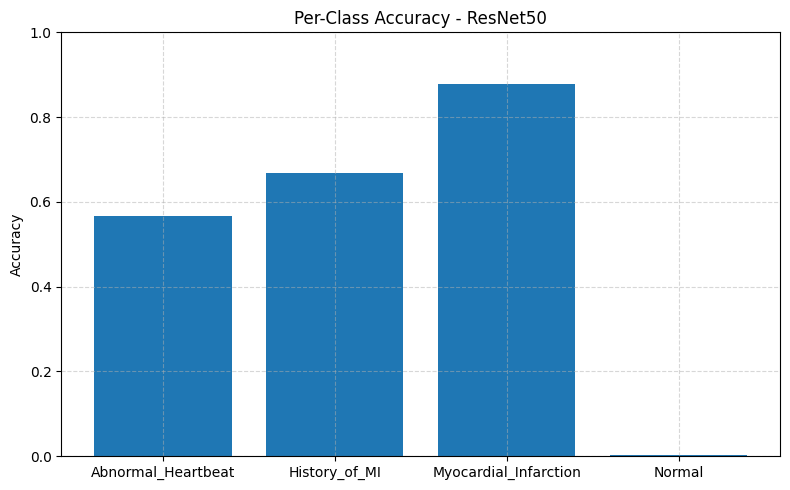

In [ ]:
plot_per_class_accuracy(model_custom, val_generator, "Custom CNN")
plot_per_class_accuracy(model_mobilenet, val_generator, "MobileNetV2")
plot_per_class_accuracy(model_optimized, val_generator, "Optimized CNN")
plot_per_class_accuracy(model_resnet, val_generator, "ResNet50")


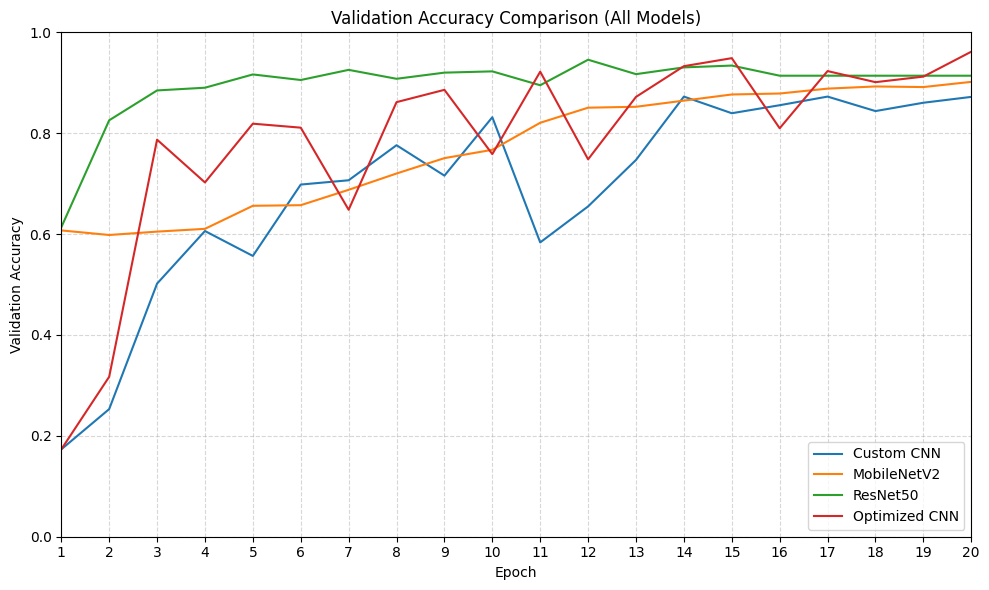

In [ ]:
import matplotlib.pyplot as plt

def plot_all_accuracy_curves_fixed(histories, model_names, max_epochs=20):
    plt.figure(figsize=(10,6))
    for hist, name in zip(histories, model_names):
        acc = hist['val_accuracy']
        if len(acc) < max_epochs:
            acc += [acc[-1]] * (max_epochs - len(acc))
        plt.plot(range(1, max_epochs + 1), acc, label=name)

    plt.title('Validation Accuracy Comparison (All Models)')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.xticks(range(1, max_epochs + 1))
    plt.ylim(0, 1.0)
    plt.xlim(1, max_epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



# Run the plot
plot_all_accuracy_curves_fixed(
    histories=[history_custom, history_mobile, history_resnet, history_optimized],
    model_names=['Custom CNN', 'MobileNetV2', 'ResNet50', 'Optimized CNN'],
    max_epochs=20
)


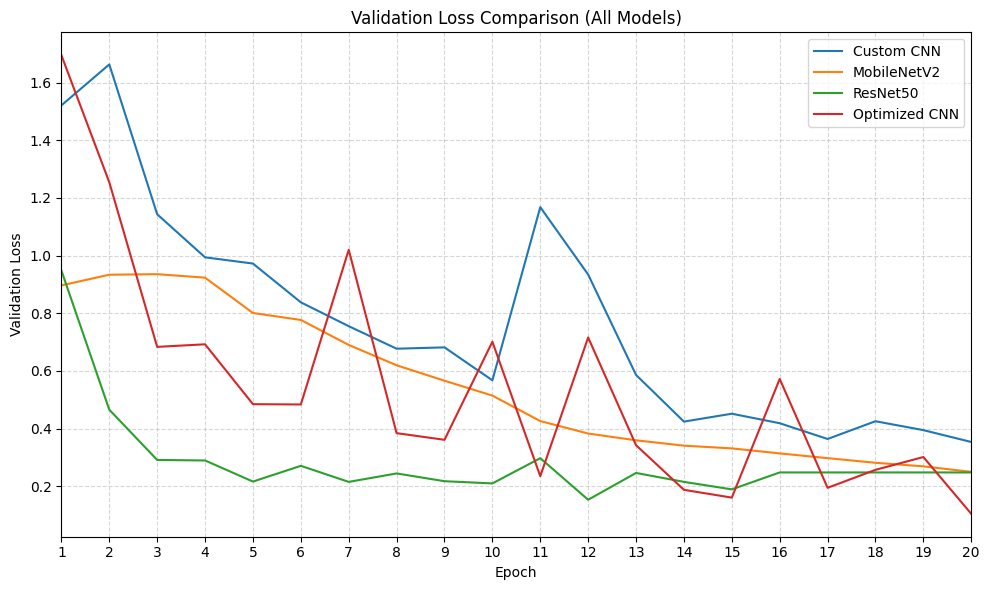

In [ ]:
def plot_all_loss_curves_fixed(histories, model_names, max_epochs=20):
    plt.figure(figsize=(10,6))
    for hist, name in zip(histories, model_names):
        loss = hist['val_loss']
        if len(loss) < max_epochs:
            loss += [loss[-1]] * (max_epochs - len(loss))
        plt.plot(range(1, max_epochs + 1), loss, label=name)

    plt.title('Validation Loss Comparison (All Models)')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.xticks(range(1, max_epochs + 1))
    plt.xlim(1, max_epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_all_loss_curves_fixed(
    histories=[history_custom, history_mobile, history_resnet, history_optimized],
    model_names=['Custom CNN', 'MobileNetV2', 'ResNet50', 'Optimized CNN'],
    max_epochs=20
)


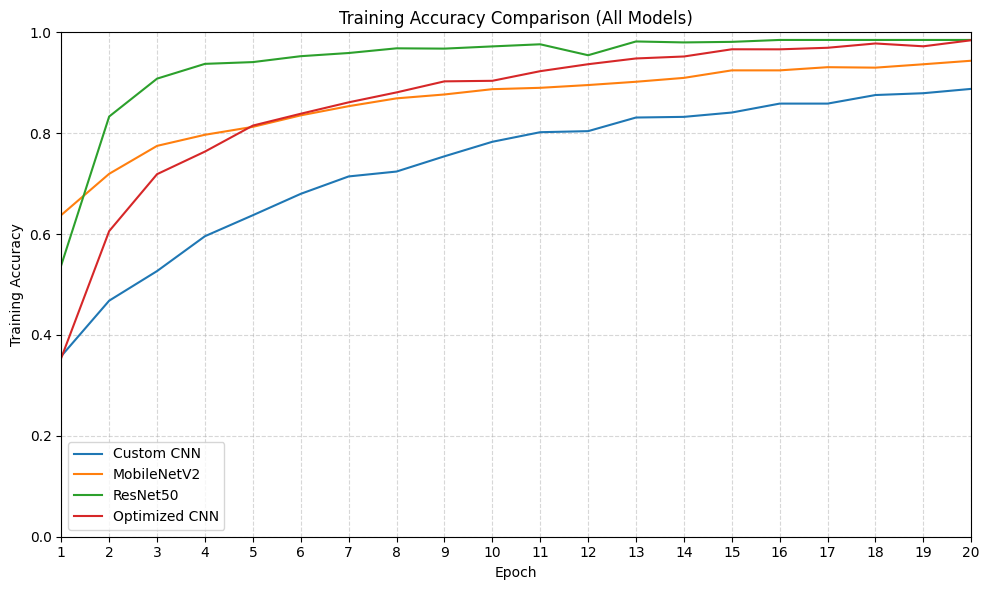

In [ ]:
def plot_all_train_accuracy_curves(histories, model_names, max_epochs=20):
    plt.figure(figsize=(10,6))
    for hist, name in zip(histories, model_names):
        acc = hist['accuracy']
        if len(acc) < max_epochs:
            acc += [acc[-1]] * (max_epochs - len(acc))  # Pad to align
        plt.plot(range(1, max_epochs + 1), acc, label=name)

    plt.title('Training Accuracy Comparison (All Models)')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.xticks(range(1, max_epochs + 1))
    plt.ylim(0, 1.0)
    plt.xlim(1, max_epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Run the updated plot
plot_all_train_accuracy_curves(
    histories=[history_custom, history_mobile, history_resnet, history_optimized],
    model_names=['Custom CNN', 'MobileNetV2', 'ResNet50', 'Optimized CNN'],
    max_epochs=20
)


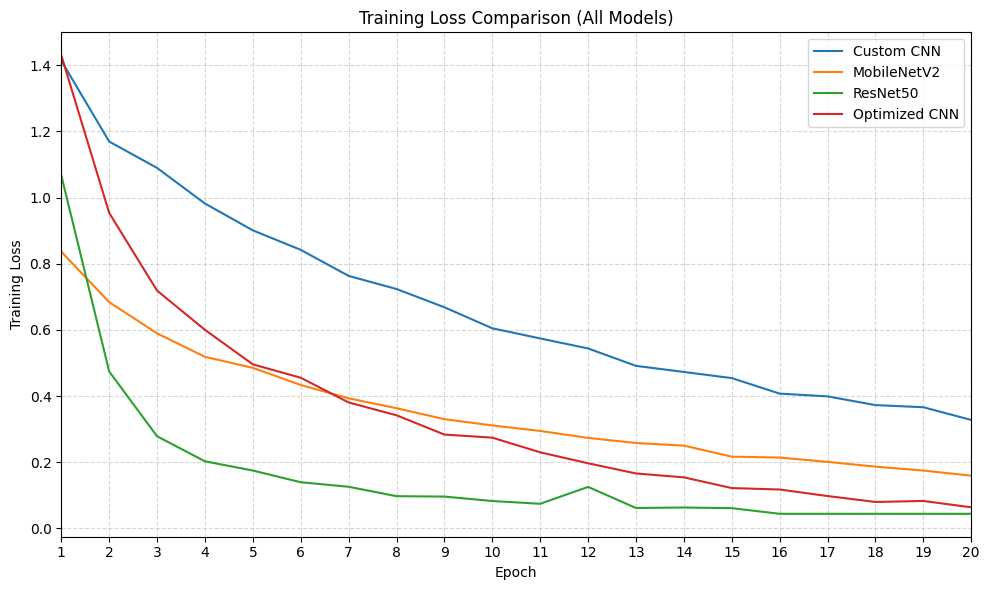

In [ ]:
def plot_all_train_loss_curves(histories, model_names, max_epochs=20):
    plt.figure(figsize=(10,6))
    for hist, name in zip(histories, model_names):
        loss = hist['loss']
        if len(loss) < max_epochs:
            loss += [loss[-1]] * (max_epochs - len(loss))  # Pad
        plt.plot(range(1, max_epochs + 1), loss, label=name)

    plt.title('Training Loss Comparison (All Models)')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.xticks(range(1, max_epochs + 1))
    plt.xlim(1, max_epochs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Run the updated plot
plot_all_train_loss_curves(
    histories=[history_custom, history_mobile, history_resnet, history_optimized],
    model_names=['Custom CNN', 'MobileNetV2', 'ResNet50', 'Optimized CNN'],
    max_epochs=20
)


In [ ]:
def plot_train_vs_val_accuracy(history, model_name):
    epochs = range(1, len(history['accuracy']) + 1)  # Start from 1
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(range(1, len(epochs)+1))  # Set explicit ticks: 1 to 20
    plt.xlim(1, len(epochs))
    plt.tight_layout()
    plt.show()


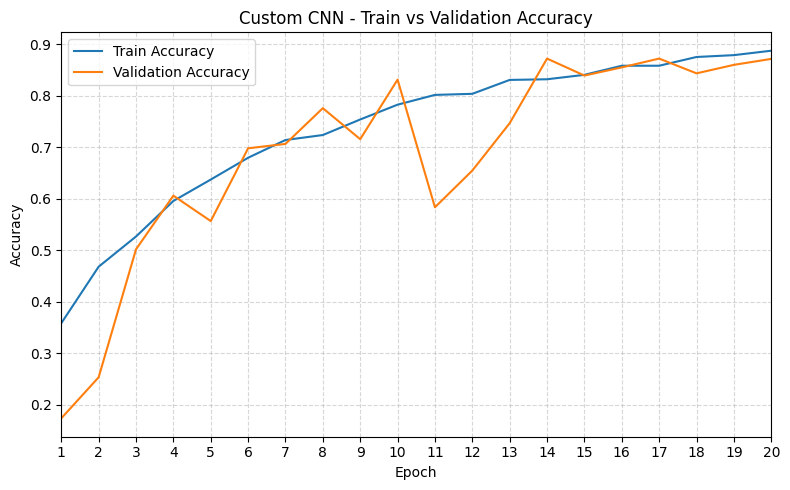

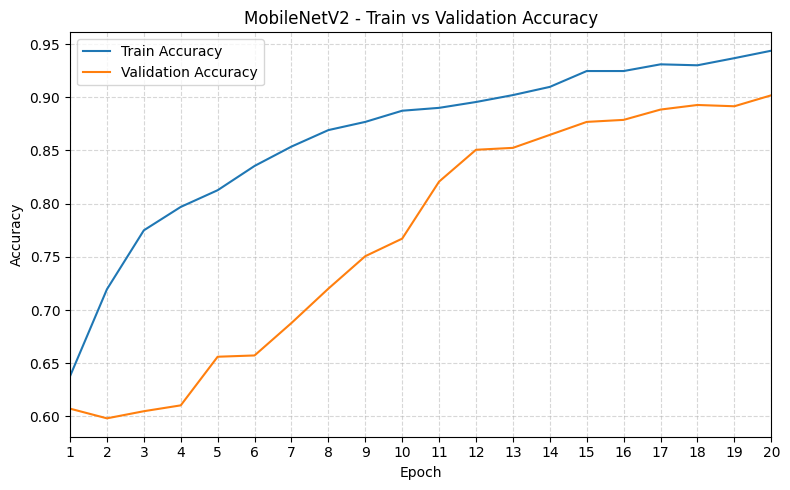

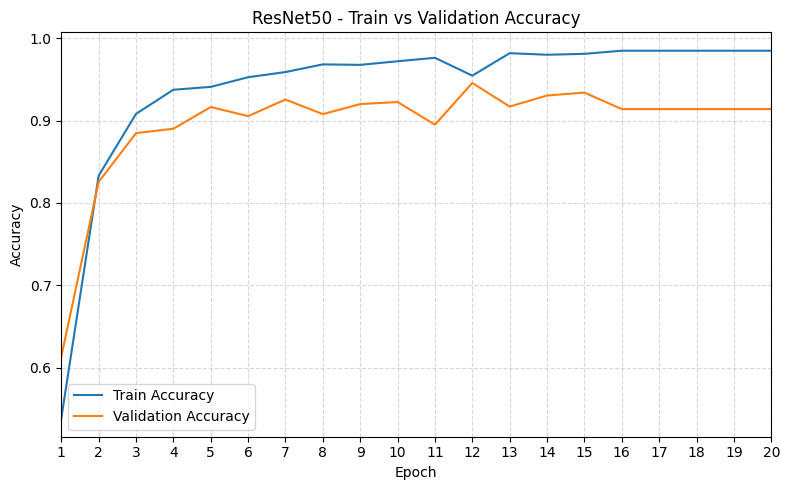

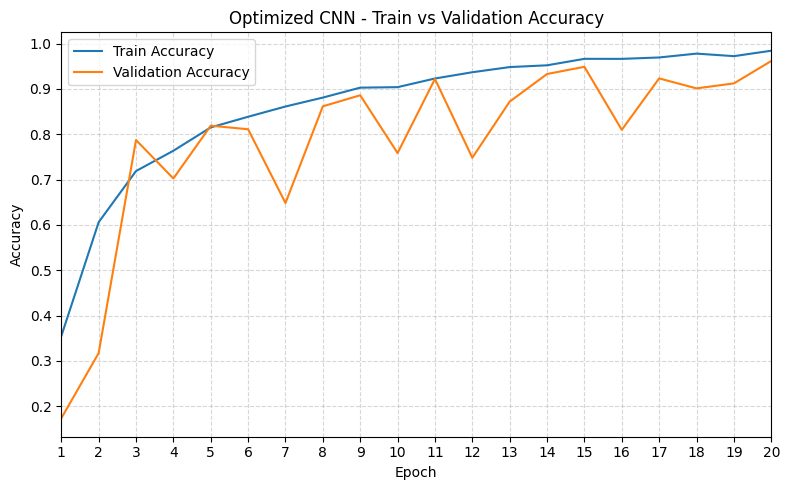

In [ ]:
plot_train_vs_val_accuracy(history_custom, "Custom CNN")
plot_train_vs_val_accuracy(history_mobile, "MobileNetV2")
plot_train_vs_val_accuracy(history_resnet, "ResNet50")
plot_train_vs_val_accuracy(history_optimized, "Optimized CNN")


In [ ]:
def plot_train_vs_val_loss(history, model_name):
    epochs = range(1, len(history['loss']) + 1)  # Start from 1
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(range(1, len(epochs)+1))  # Show ticks from 1 to 20
    plt.xlim(1, len(epochs))
    plt.tight_layout()
    plt.show()


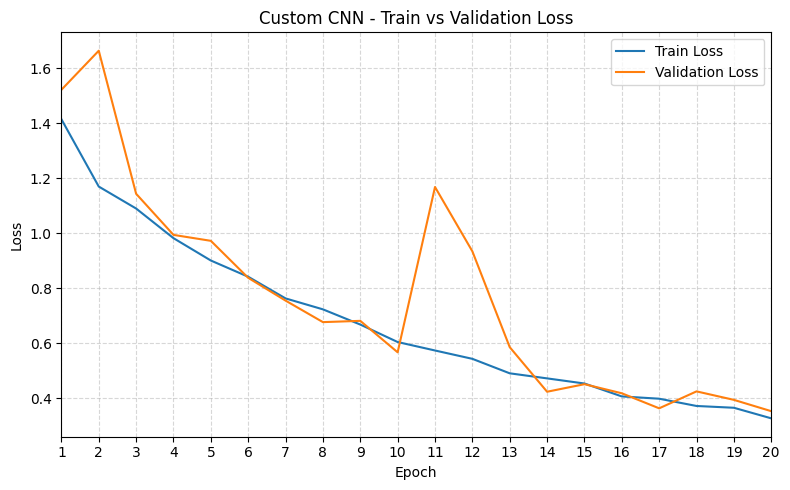

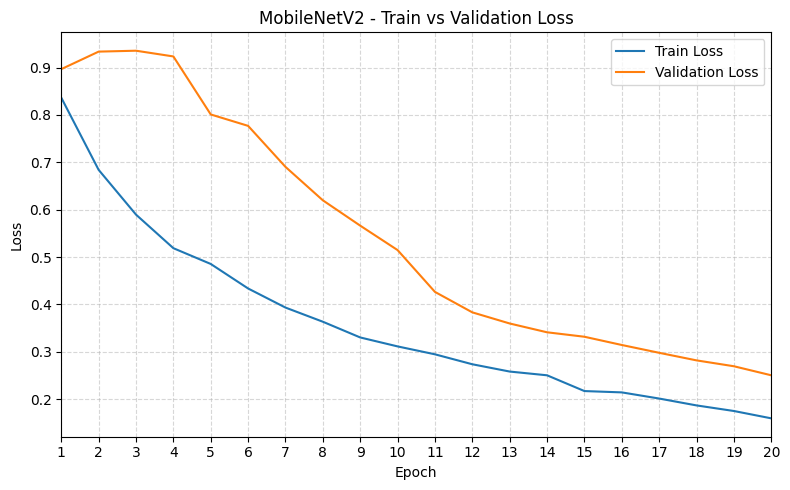

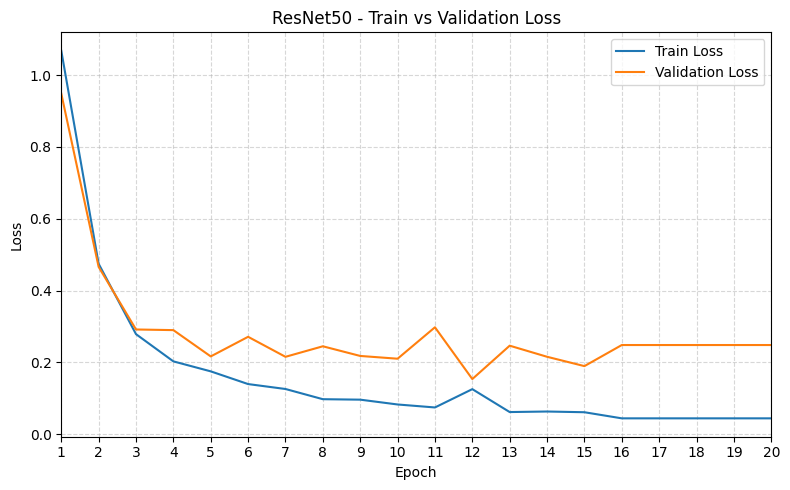

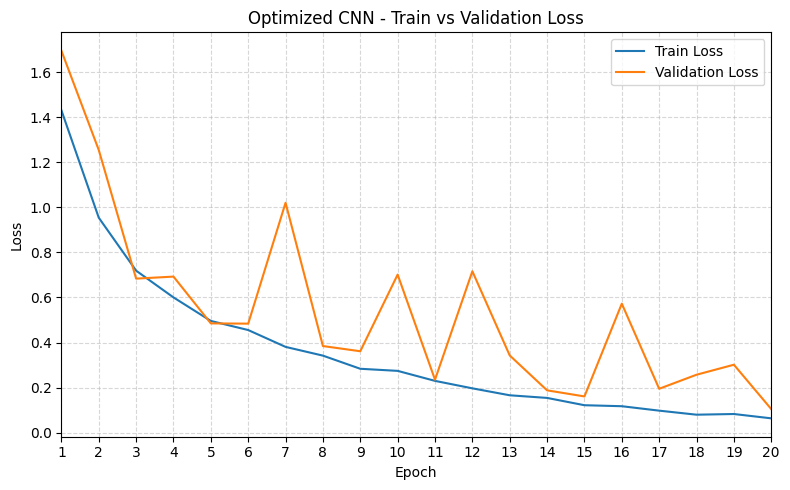

In [ ]:
plot_train_vs_val_loss(history_custom, "Custom CNN")
plot_train_vs_val_loss(history_mobile, "MobileNetV2")
plot_train_vs_val_loss(history_resnet, "ResNet50")
plot_train_vs_val_loss(history_optimized, "Optimized CNN")
